## A sanity test to debug DL model to detect stick-slip 

In [205]:
import sys
sys.path.append('/home/zhay/DEEP/python/')
sys.path.append('/home/zhay/DEEP/python/lib/')
import scipy as sp
import pandas as pd
import numpy as np
import pickle
from time import time
import matplotlib.pyplot as plt
from scipy import signal
from StickSlipDetector import StickSlipDetector
from keras.models import Model,load_model, save_model
from keras.layers import Input,LSTM,Dense,Conv1D,MaxPooling1D,Dropout,BatchNormalization,Flatten
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
import keras
from keras_utility import precision, recall, binary_xentropy, fmeasure, augmentData
from keras.utils.vis_utils import model_to_dotel_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam

from IPython.display import SVG
import deep_util
%matplotlib notebook

In [28]:
dataOnlyFile='/home/zhay/DEEP/machineLearning/stickslipDetector/trainingData_5000-11400ft_xy.p'

with open(dataOnlyFile,'rb') as file:
    trainingDict=pickle.load(file)


X=trainingDict['X']
#  y=trainingDict['y']
X.shape

(2475, 3000, 3)

### Help function to generate target

In [186]:
def calcTarget(X,threshold = 2):
    Y=np.zeros((X.shape[0],X.shape[1]))
#    calculate threshold value from input time series
    nsample=X.shape[0]
    for j in range(nsample):
#         for each channel|
        for ic in range(X.shape[2]): 
            indHigh=np.abs(X[j,:,ic])>threshold*np.std(X[j,:,ic])
#             ind = np.arange(indHigh,indHigh+5)
#             ind
            Y[j,indHigh]+=1
    return Y

def insert_ones(z,spread):
    nsample=z.shape[0]
    ind_end=np.where(np.diff(z)<0)[0]
    for ind in ind_end:
        z[ind+1:ind+spread+1]=1
    return z

def distributeTarget(Y,highlimit=2,spread=5):
    nsample=Y.shape[0]
    nt=Y.shape[1]
    Z=np.zeros((Y.shape[0],Y.shape[1]))

    for j in range(nsample):
        Z[j,Y[j,:]>=highlimit]=1
        Z[j,:] = insert_ones(Z[j,:],spread)
    return Z




In [187]:
# a=np.array((0,0,1,0,1,0,0))
# insert_ones(a,spread=1)
# np.where(np.diff(a)<0)

Y=calcTarget(X,threshold=2)
Z=distributeTarget(Y,highlimit=2,spread=5)
# ind_end=np.diff(Z[0,:]<0)
# ind_end=np.where(np.diff(Z[2,:])<0)
# ind_end[0]

### Plot random example data and target 

<IPython.core.display.Javascript object>


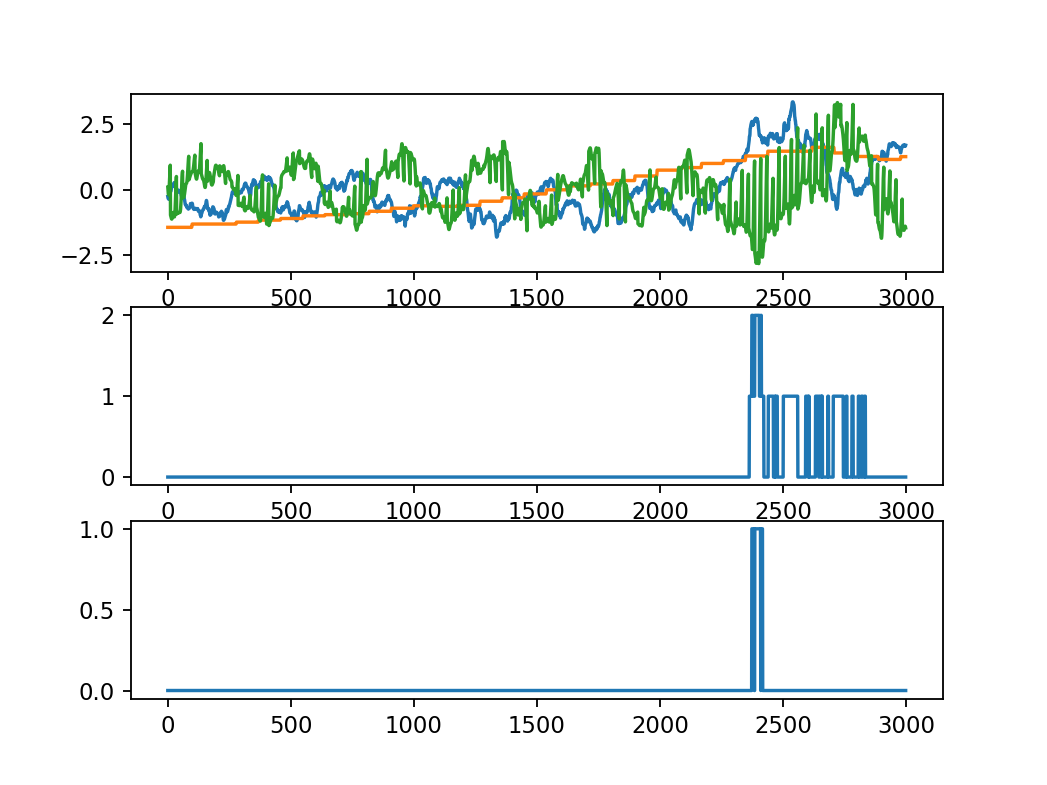

In [192]:
# Plot sample
m=np.random.randint(0,X.shape[0])
plt.figure(dpi=150)
ax1=plt.subplot(311)
plt.plot(X[m,:,0])
plt.plot(X[m,:,1])
plt.plot(X[m,:,2])

plt.show()


# Plot sample
ax2=plt.subplot(312,sharex=ax1)
plt.plot(Y[m,:])
# plt.plot(Y[m,:,1])
# plt.plot(Y[m,:,2])

ax3=plt.subplot(313,sharex=ax1)
plt.plot(Z[m,:])
# plt.plot(Y[m,:,1])
# plt.plot(Y[m,:,2])
plt.show()

In [193]:
def multiChannelTimeSeriesModel(input_shape,nfilter=32,filtersize=8,stride=1,dropoutRate=0.5,nUnitRNN=16):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)
    nfilter -- number of filter in the first conv layer
    filtersize -- length of the kernal
    stride -- stride for the conv model
    
    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
#     X = Conv1D(filters=nfilter, kernel_size=filtersize, strides=stride,padding='same')(X_input)                       # CONV1D
    X = BatchNormalization()(X_input)                                 # Batch normalization
    X = Activation(activation='relu')(X)                                 # ReLu activation
    X = Dropout(dropoutRate)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = nUnitRNN, return_sequences = True)(X)                                # GRU (use 128 units and return the sequences)
    X = Dropout(dropoutRate)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = nUnitRNN, return_sequences = True)(X)                                 # GRU (use 128 units and return the sequences)
    X = Dropout(dropoutRate)(X)                                 # dropout (use 0.8
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Dropout(dropoutRate)(X)                                 # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1))(X) # time distributed

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model 

### Separate training ans dev data

In [195]:
trainPerc=0.7
nsample=X.shape[0]
idxArray=np.arange(0,nsample)

np.random.seed(5)
np.random.shuffle(idxArray)
idx_train=idxArray[0:np.int(nsample*trainPerc)]
idx_test=idxArray[np.int(nsample*trainPerc):]
#   
#    reshape to 4D 
X_train=X[idx_train]
# x_aux_train=x_aux[idx_train]
Y_train=Z[idx_train]

X_test=X[idx_test]
# x_aux_test=x_aux[idx_test]
Y_test=Z[idx_test]
X_test.shape

(743, 3000, 3)

In [203]:
nc,nt=X[0].shape


model=multiChannelTimeSeriesModel(input_shape=(nc,nt),nUnitRNN=16)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3000, 3)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 3000, 3)           12        
_________________________________________________________________
activation_5 (Activation)    (None, 3000, 3)           0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 3000, 3)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 3000, 16)          960       
_________________________________________________________________
dropout_18 (Dropout)         (None, 3000, 16)          0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 3000, 16)          64        
__________

In [206]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='mean_squared_error',optimizer=opt,metrics=['accuracy'])
earlyStop=keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.0,
                              patience=2,
                              verbose=0, mode='auto')

In [207]:
History=model.fit(X_train, Y_train, 
              batch_size=32,
              epochs=1000,
              validation_data=(X_test,Y_test),
#               callbacks=[earlyStop],
              shuffle=True,verbose=1)
# ssd.setModelParameters(lr=0.001,strides=4,poolingSize=4,nfilter=nfilter,filterLength=filterLength,patience=10)

score=model.evaluate(X_test,Y_test,batch_size=32)

ValueError: Error when checking target: expected time_distributed_5 to have 3 dimensions, but got array with shape (1732, 3000)